# Initialisation

In [1]:
# Cellule 1: Configuration et imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
import os
from sklearn.preprocessing import OneHotEncoder
warnings.filterwarnings('ignore')

# Ajouter le répertoire parent au path pour accéder à config
sys.path.append('..')

# Importer les configurations
from config.parameters import DATA_CONFIG, EDA_CONFIG, INSURANCE_CONFIG

# Configuration d'affichage
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8')


In [2]:
# Utiliser les paramètres de configuration
data_path = DATA_CONFIG['raw_data_path']
train_file = DATA_CONFIG['train_file']
target_col = DATA_CONFIG['target_column']

# Corriger le chemin relatif depuis le dossier notebooks
# Le chemin dans config est relatif à la racine du projet
full_path = os.path.join('..', data_path, train_file)

# Charger les données
df_train = pd.read_csv(full_path)
print(f"Données chargées: {df_train.shape}")

print(f"=== EXPLORATION DE {target_col} ===")
print(f"Fichier: {train_file}")
print(f"Nombre de lignes: {len(df_train)}")

Données chargées: (22481, 15)
=== EXPLORATION DE PrimeCommerciale ===
Fichier: X_train.csv
Nombre de lignes: 22481


# ANALYSE CLASSIFICATION MÉTIER 

In [3]:

# Variables d'identification
id_vars = ['PolicyId'] 

# Variable cible
target_var = ['PrimeCommerciale']

# Variables démographiques du conducteur
demographic_vars = ['AgeConducteur', 'SexeConducteur', 'StatutMatrimonial']

# Variables métier assurance
insurance_vars = ['BonusMalus', 'FrequencePaiement', 'CodeProfession']

# Variables véhicule
vehicle_vars = ['AgeVehicule', 'ClasseVehicule', 'PuissanceVehicule', 
                'CarburantVehicule', 'UsageVehicule']

# Variables contextuelles
context_vars = ['Garage', 'Region']

print("=== CLASSIFICATION DES VARIABLES ===")
print(f"Variables d'identification: {id_vars}")
print(f"Variable cible: {target_var}")
print(f"Variables démographiques: {demographic_vars}")
print(f"Variables assurance: {insurance_vars}")
print(f"Variables véhicule: {vehicle_vars}")
print(f"Variables contextuelles: {context_vars}")

=== CLASSIFICATION DES VARIABLES ===
Variables d'identification: ['PolicyId']
Variable cible: ['PrimeCommerciale']
Variables démographiques: ['AgeConducteur', 'SexeConducteur', 'StatutMatrimonial']
Variables assurance: ['BonusMalus', 'FrequencePaiement', 'CodeProfession']
Variables véhicule: ['AgeVehicule', 'ClasseVehicule', 'PuissanceVehicule', 'CarburantVehicule', 'UsageVehicule']
Variables contextuelles: ['Garage', 'Region']


# ANALYSE PRIME COMMERCIALE 

In [4]:
target_col = DATA_CONFIG["target_column"]

# Statistiques descriptives complètes
print("Statistiques descriptives:")
print(df_train[target_col].describe())

# Utiliser les paramètres de configuration pour les seuils
prime_categories = INSURANCE_CONFIG['prime_categories']
print(f"\nCatégories de primes (config): {prime_categories}")

# Créer des segments de prime selon la configuration
def categorize_prime(prime):
    if prime <= prime_categories['low'][1]:
        return 'low'
    elif prime <= prime_categories['medium'][1]:
        return 'medium'
    else:
        return 'high'
    

df_train['prime_category'] = df_train[target_col].apply(categorize_prime)
print("\nRépartition par catégorie de prime:")
print(df_train['prime_category'].value_counts())


Statistiques descriptives:
count    22481.000000
mean       420.786077
std        219.261080
min         91.000000
25%        264.800000
50%        375.100000
75%        521.300000
max       2902.300000
Name: PrimeCommerciale, dtype: float64

Catégories de primes (config): {'low': (0, 500), 'medium': (500, 1500), 'high': (1500, inf)}

Répartition par catégorie de prime:
prime_category
low       16245
medium     6184
high         52
Name: count, dtype: int64


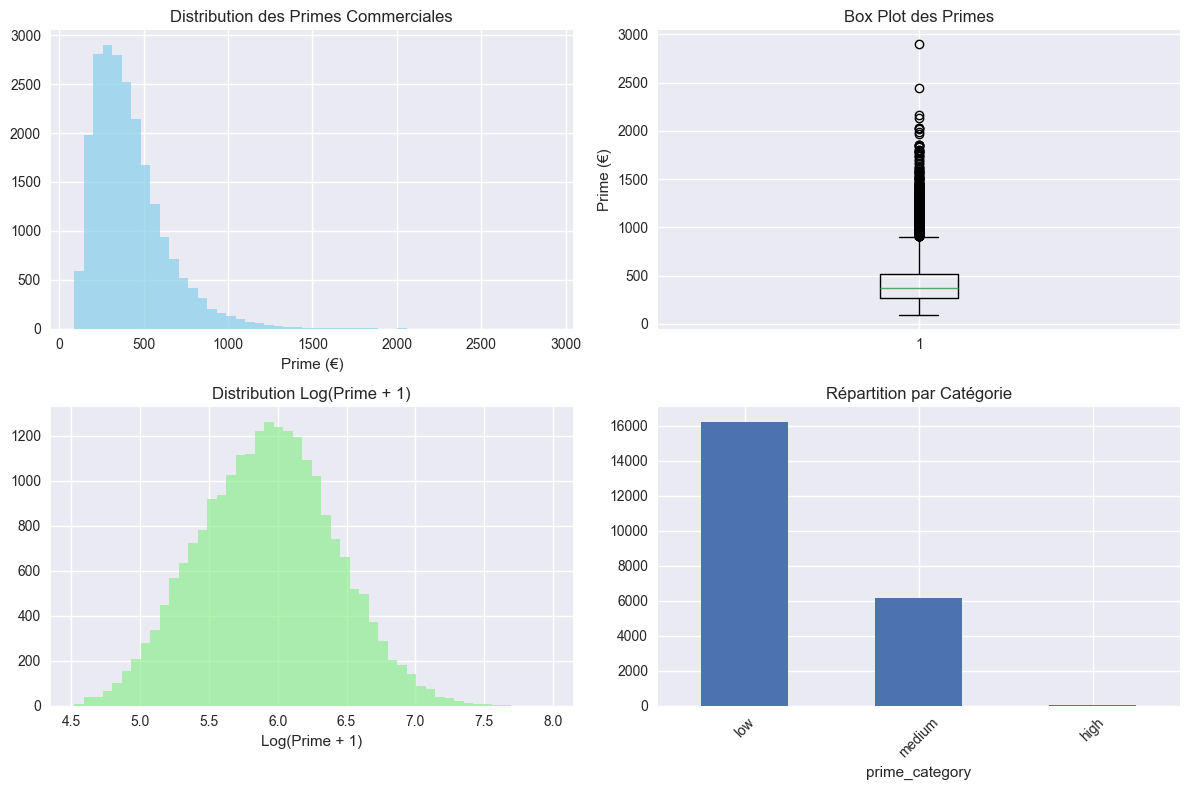

In [5]:
# Visualisations avec paramètres EDA
figsize = EDA_CONFIG['figsize']
plt.figure(figsize=figsize)

plt.subplot(2, 2, 1)
df_train[target_col].hist(bins=50, alpha=0.7, color='skyblue')
plt.title('Distribution des Primes Commerciales')
plt.xlabel('Prime (€)')

plt.subplot(2, 2, 2)
plt.boxplot(df_train[target_col])
plt.title('Box Plot des Primes')
plt.ylabel('Prime (€)')

plt.subplot(2, 2, 3)
np.log1p(df_train[target_col]).hist(bins=50, alpha=0.7, color='lightgreen')
plt.title('Distribution Log(Prime + 1)')
plt.xlabel('Log(Prime + 1)')

plt.subplot(2, 2, 4)
df_train['prime_category'].value_counts().plot(kind='bar')
plt.title('Répartition par Catégorie')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# ANALYSE DÉMOGRAPHIQUE 

In [6]:
demo_vars = [var for var in demographic_vars if var in df_train.columns]

for var in demo_vars:
    print(f"\n--- Analyse de {var} ---")
    
    if var == 'AgeConducteur':
        # Utiliser les catégories d'âge de la configuration
        age_cats = INSURANCE_CONFIG['age_categories']
        print(f"Catégories d'âge (config): {age_cats}")
        
        print("Statistiques d'âge:")
        print(df_train['AgeConducteur'].describe())
        
        # Créer des tranches selon la configuration
        def categorize_age(age):
            if age <= age_cats['jeune'][1]:
                return 'jeune'
            elif age <= age_cats['adulte'][1]:
                return 'adulte'
            else:
                return 'senior'
        
        df_train['age_category'] = df_train['AgeConducteur'].apply(categorize_age)
        print("\nRépartition par tranche d'âge:")
        print(df_train['age_category'].value_counts())
        
        # Impact sur la prime
        print("\nPrime moyenne par tranche d'âge:")
        print(df_train.groupby('age_category')[target_col].agg(['mean', 'count']))

    
    else:
        # Variables catégorielles
        print("Répartition des modalités:")
        print(df_train[var].value_counts())
        
        # Impact sur la prime
        print(f"\nPrime moyenne par {var}:")
        prime_by_category = df_train.groupby(var)[target_col].agg(['mean', 'median', 'count'])
        print(prime_by_category)



--- Analyse de AgeConducteur ---
Catégories d'âge (config): {'jeune': (18, 25), 'adulte': (26, 60), 'senior': (61, 100)}
Statistiques d'âge:
count    22481.000000
mean        39.719185
std         11.854692
min         18.000000
25%         31.000000
50%         37.000000
75%         47.000000
max         87.000000
Name: AgeConducteur, dtype: float64

Répartition par tranche d'âge:
age_category
adulte    19298
jeune      1706
senior     1477
Name: count, dtype: int64

Prime moyenne par tranche d'âge:
                    mean  count
age_category                   
adulte        413.166841  19298
jeune         546.531184   1706
senior        375.095396   1477

--- Analyse de SexeConducteur ---
Répartition des modalités:
SexeConducteur
M    14809
F     7672
Name: count, dtype: int64

Prime moyenne par SexeConducteur:
                      mean  median  count
SexeConducteur                           
F               389.985597  347.15   7672
M               436.742677  391.40  14809

--- 

# ANALYSE VARIABLES MÉTIER

In [7]:
insurance_vars_available = [var for var in insurance_vars if var in df_train.columns]

for var in insurance_vars_available:
    print(f"\n--- Analyse de {var} ---")
    
    if var == 'BonusMalus':
        # Utiliser les paramètres de configuration
        bonus_range = INSURANCE_CONFIG['bonus_malus_range']
        print(f"Plage attendue Bonus/Malus: {bonus_range}")
        
        # Statistiques
        print("Statistiques Bonus/Malus:")
        print(df_train[var].describe())
        
        # Contrôles de cohérence métier
        invalid_bonus = df_train[(df_train[var] < bonus_range[0]) | (df_train[var] > bonus_range[1])]
        print(f"Valeurs invalides: {len(invalid_bonus)} ({len(invalid_bonus)/len(df_train)*100:.2f}%)")
        
        # Catégorisation métier
        def categorize_bonus_malus(bm):
            if bm < 100:
                return 'bonus'
            elif bm == 100:
                return 'neutre'
            else:
                return 'malus'
        
        df_train['bonus_malus_category'] = df_train[var].apply(categorize_bonus_malus)
        print("\nRépartition Bonus/Malus:")
        print(df_train['bonus_malus_category'].value_counts())
        
        # Impact sur la prime
        print("\nPrime moyenne par catégorie Bonus/Malus:")
        print(df_train.groupby('bonus_malus_category')[target_col].agg(['mean', 'std', 'count']))
    
    else:
        # Autres variables métier
        print("Répartition des modalités:")
        print(df_train[var].value_counts())
        
        # Cardinalité (important pour l'encodage)
        n_categories = df_train[var].nunique()
        print(f"Nombre de modalités uniques: {n_categories}")
        
        if n_categories <= 10:  # Variables à faible cardinalité
            print(f"\nPrime moyenne par {var}:")
            print(df_train.groupby(var)[target_col].agg(['mean', 'count']))
        else:  # Variables à forte cardinalité
            print(f"\nTop 10 modalités pour {var}:")
            top_categories = df_train[var].value_counts().head(10)
            print(top_categories)



--- Analyse de BonusMalus ---
Plage attendue Bonus/Malus: (50, 350)
Statistiques Bonus/Malus:
count    22481.000000
mean        63.242471
std         15.381818
min         50.000000
25%         50.000000
50%         57.000000
75%         72.000000
max        156.000000
Name: BonusMalus, dtype: float64
Valeurs invalides: 0 (0.00%)

Répartition Bonus/Malus:
bonus_malus_category
bonus     21878
malus       331
neutre      272
Name: count, dtype: int64

Prime moyenne par catégorie Bonus/Malus:
                            mean         std  count
bonus_malus_category                               
bonus                 412.889304  210.250963  21878
malus                 752.361934  355.469683    331
neutre                652.455147  268.935473    272

--- Analyse de FrequencePaiement ---
Répartition des modalités:
FrequencePaiement
Half-yearly    12486
Annual          7680
Quarterly       1709
Monthly          606
Name: count, dtype: int64
Nombre de modalités uniques: 4

Prime moyenne par F

# ANALYSE VARIABLES VÉHICULE

In [8]:
vehicle_vars_available = [var for var in vehicle_vars if var in df_train.columns]

for var in vehicle_vars_available:
    print(f"\n--- Analyse de {var} ---")
    
    if var == 'AgeVehicule':
        print("Statistiques âge véhicule:")
        print(df_train[var].describe())
        
        # Cohérence métier: véhicule plus vieux que conducteur
        if 'AgeConducteur' in df_train.columns:
            inconsistent_ages = df_train[df_train[var] > df_train['AgeConducteur']]
            print(f"Véhicules plus vieux que conducteur: {len(inconsistent_ages)} ({len(inconsistent_ages)/len(df_train)*100:.2f}%)")
        
        # Catégorisation véhicule
        def categorize_vehicle_age(age):
            if age <= 3:
                return 'neuf'
            elif age <= 7:
                return 'recent'
            else:
                return 'ancien'
        
        df_train['vehicle_age_category'] = df_train[var].apply(categorize_vehicle_age)
        print("\nRépartition par âge véhicule:")
        print(df_train['vehicle_age_category'].value_counts())
        
        # Impact sur la prime
        print("\nPrime moyenne par âge véhicule:")
        print(df_train.groupby('vehicle_age_category')[target_col].agg(['mean', 'count']))
    
    else:
        # Variables catégorielles véhicule
        print("Répartition des modalités:")
        vehicle_counts = df_train[var].value_counts()
        print(vehicle_counts.head(10))  # Top 10 seulement
        
        n_categories = df_train[var].nunique()
        print(f"Nombre total de modalités: {n_categories}")
        
        # Pour les variables à cardinalité raisonnable, analyser l'impact sur la prime
        if n_categories <= 20:
            print(f"\nPrime moyenne par {var} (top 10):")
            top_categories = df_train[var].value_counts().head(10).index
            prime_impact = df_train[df_train[var].isin(top_categories)].groupby(var)[target_col].mean().sort_values(ascending=False)
            print(prime_impact)



--- Analyse de AgeVehicule ---
Statistiques âge véhicule:
count    22481.000000
mean         7.505805
std          4.848366
min          0.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         89.000000
Name: AgeVehicule, dtype: float64
Véhicules plus vieux que conducteur: 29 (0.13%)

Répartition par âge véhicule:
vehicle_age_category
ancien    10457
recent     7187
neuf       4837
Name: count, dtype: int64

Prime moyenne par âge véhicule:
                            mean  count
vehicle_age_category                   
ancien                319.448370  10457
neuf                  561.027000   4837
recent                473.846195   7187

--- Analyse de ClasseVehicule ---
Répartition des modalités:
ClasseVehicule
Cheapest          7839
Cheaper           6514
Cheap             3893
Medium low        2419
Medium             847
Medium high        592
Expensive          246
More expensive      94
Most expensive      37
Name: count, dtype: int64
Nombre total d

# CONTRÔLES COHÉRENCE 

In [9]:
# Utiliser les paramètres de configuration pour les contrôles
issues = []

# 1. Contrôle Bonus/Malus
if 'BonusMalus' in df_train.columns:
    bonus_range = INSURANCE_CONFIG['bonus_malus_range']
    invalid_bonus = df_train[(df_train['BonusMalus'] < bonus_range[0]) | 
                            (df_train['BonusMalus'] > bonus_range[1])]
    if len(invalid_bonus) > 0:
        issues.append(f"BonusMalus invalide: {len(invalid_bonus)} cas")

# 2. Contrôle Prime Commerciale
if target_col in df_train.columns:
    negative_primes = df_train[df_train[target_col] <= 0]
    if len(negative_primes) > 0:
        issues.append(f"Primes nulles/négatives: {len(negative_primes)} cas")

# 3. Contrôle cohérence âges
if all(col in df_train.columns for col in ['AgeConducteur', 'AgeVehicule']):
    illogical_ages = df_train[df_train['AgeVehicule'] > df_train['AgeConducteur']]
    if len(illogical_ages) > 0:
        issues.append(f"Âges incohérents: {len(illogical_ages)} cas")

# 4. Contrôle valeurs manquantes avec seuil configuré
missing_threshold = EDA_CONFIG['missing_threshold']
for col in df_train.columns:
    missing_pct = df_train[col].isnull().sum() / len(df_train)
    if missing_pct > missing_threshold:
        issues.append(f"{col}: {missing_pct*100:.1f}% de valeurs manquantes")

print("Issues détectées:")
for issue in issues:
    print(f"- {issue}")

if not issues:
    print("Aucun problème de cohérence majeur détecté")


Issues détectées:
- Âges incohérents: 29 cas
- StatutMatrimonial: 67.2% de valeurs manquantes
- CodeProfession: 67.2% de valeurs manquantes


# ANALYSE CORRÉLATIONS 

=== ANALYSE DES CORRÉLATIONS ===
Variables numériques analysées: ['AgeConducteur', 'BonusMalus', 'AgeVehicule', 'PrimeCommerciale']


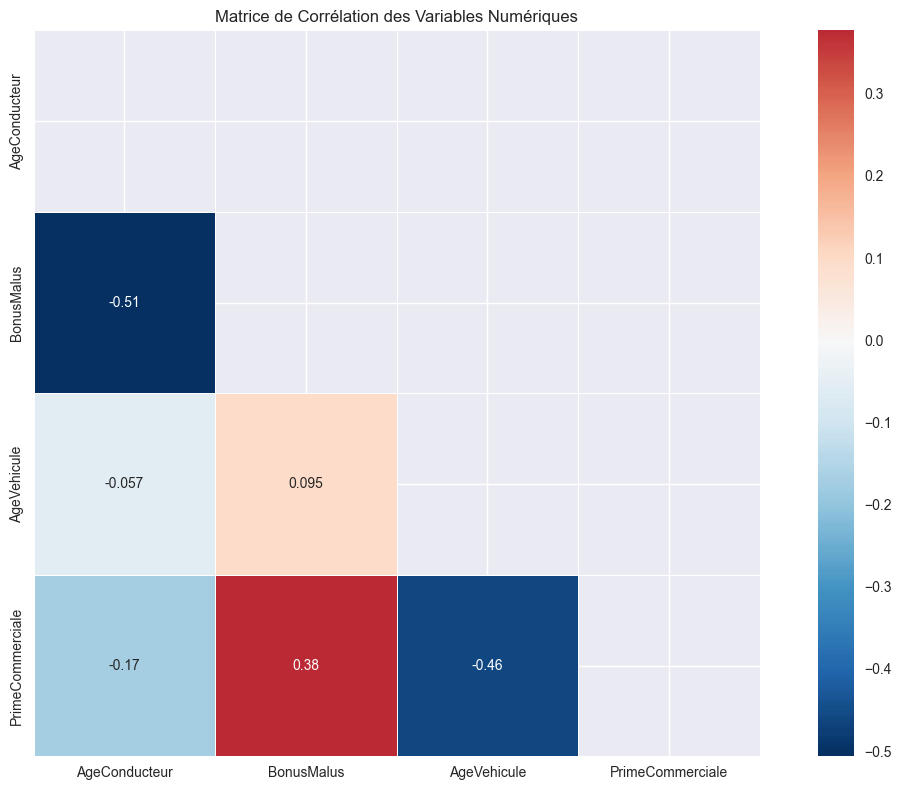


Corrélations élevées (|r| > 0.8):
Pas de corrélations élevées détectées


In [10]:
# Sélectionner les variables numériques disponibles
numeric_vars = df_train.select_dtypes(include=[np.number]).columns.tolist()

# Exclure l'ID et inclure la cible
if 'PolicyId' in numeric_vars:
    numeric_vars.remove('PolicyId')

print(f"=== ANALYSE DES CORRÉLATIONS ===")
print(f"Variables numériques analysées: {numeric_vars}")

# Matrice de corrélation
corr_matrix = df_train[numeric_vars].corr()

# Utiliser le seuil de corrélation de la configuration
correlation_threshold = EDA_CONFIG['correlation_threshold']

# Visualisation avec paramètres configurés
figsize = EDA_CONFIG['figsize']
plt.figure(figsize=figsize)

# Masque pour le triangle supérieur
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5)
plt.title('Matrice de Corrélation des Variables Numériques')
plt.tight_layout()
plt.show()

# Identifier les corrélations élevées
print(f"\nCorrélations élevées (|r| > {correlation_threshold}):")
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > correlation_threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))

for var1, var2, corr_val in high_corr_pairs:
    print(f"- {var1} × {var2}: {corr_val:.3f}")

if not high_corr_pairs:
    print("Pas de corrélations élevées détectées")


# SYNTHÈSE EXPLORATION 

In [11]:
print(f"Dataset: {df_train.shape[0]} observations, {df_train.shape[1]} variables")
print(f"Variable cible: {target_col}")
print(f"Prime moyenne: {df_train[target_col].mean():.2f}€")
print(f"Prime médiane: {df_train[target_col].median():.2f}€")

total_missing = df_train.isnull().sum().sum()
print(f"Total valeurs manquantes: {total_missing}")
print(f"Pourcentage complet: {(1 - total_missing/(df_train.shape[0]*df_train.shape[1]))*100:.1f}%")

print("\n=== VARIABLES PAR CATÉGORIE ===")
print(f"Variables démographiques: {len([v for v in demographic_vars if v in df_train.columns])}")
print(f"Variables métier assurance: {len([v for v in insurance_vars if v in df_train.columns])}")
print(f"Variables véhicule: {len([v for v in vehicle_vars if v in df_train.columns])}")
print(f"Variables contextuelles: {len([v for v in context_vars if v in df_train.columns])}")

feature_vars = [col for col in df_train.columns if col not in ['PolicyId', target_col]]
print(f"\nVariables features identifiées: {len(feature_vars)}")


Dataset: 22481 observations, 19 variables
Variable cible: PrimeCommerciale
Prime moyenne: 420.79€
Prime médiane: 375.10€
Total valeurs manquantes: 30218
Pourcentage complet: 92.9%

=== VARIABLES PAR CATÉGORIE ===
Variables démographiques: 3
Variables métier assurance: 3
Variables véhicule: 5
Variables contextuelles: 2

Variables features identifiées: 17
